In [594]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [639]:
sentiment_values = pd.read_csv('C:/Users/20221509/Desktop/Sociophysics/redditpostsRevelant.csv')
sentiment_values = sentiment_values[['created_utc', 'text_sentiment_score']]
sentiment_values['created_utc'] = pd.to_datetime(sentiment_values['created_utc'])
sentiment_values = sentiment_values.rename({'created_utc':'ds'}, axis='columns')
sentiment_values = sentiment_values.set_index('ds')
sentiment_values.sort_index(inplace=True)

In [640]:
sentiment_values = sentiment_values[['text_sentiment_score']].resample('D').sum()
array_sentiment_values = np.array(sentiment_values)
#array_sentiment_values = array_sentiment_values + 0.1
#array_sentiment_values = np.absolute(array_sentiment_values)
#array_sentiment_values = 10*array_sentiment_values/np.max(array_sentiment_values)
print(np.min(array_sentiment_values))
print(np.max(array_sentiment_values))
print(np.mean(array_sentiment_values))


-359.2410999999956
446.39789999999914
12.708504377104392


In [655]:
class Redditor:
    def __init__(self, susceptibility, financial_satisfaction, anxiety, capital):
        self.s = susceptibility
        self.a = anxiety
        self.fs = financial_satisfaction
        self.c0 = capital
        self.c = capital
        self.conviction = 0
        self.invested = 0
        self.buy_price = 0
        
    def convince(self, sentiment, price):
        if self.conviction == 0 and sentiment < 0:
            self.conviction = 0
        else:
            self.conviction += self.s*sentiment
        self.a += self.s*price
        self.fs = np.abs(self.a*(self.c + self.invested)/self.c0)   
        
    def buy_or_sell(self, price, bought_in, buy_counter, sell_counter):
        
        #Bought In:
        if self.conviction > bought_in:
            self.invested = self.c/5
            buy_counter += self.c/5
            self.c -= self.c/5
            self.buy_price = price
            
            if self.invested > 0:
                if price > 1.2*self.buy_price:
                    self.c += 1.2*self.invested
                    sell_counter += 1.2*self.invested
                    self.invested = 0 
                        
                elif price < 0.8*self.buy_price:
                    self.c += 0.8*self.invested
                    sell_counter += 0.8*self.invested
                    self.invested = 0


        #Unconvinced: 
        if self.conviction <= bought_in and self.invested > 0:
            if price > 1.1*self.buy_price:
                sell_counter += 1.1*self.invested
                self.c += 1.1*self.invested
                self.invested = 0
            elif price < 0.9*self.buy_price:
                sell_counter += 0.9*self.invested
                self.c += 0.9*self.invested
                self.invested = 0
            
        return buy_counter, sell_counter
    
    
class Shorter:
    def __init__(self, susceptibility, short_duration, capital):
        self.s = susceptibility
        self.c = capital
        self.short_duration = short_duration
        self.invested = 0
        self.short_time = 0
        self.short_price = 0
        self.shorted = False
        
    def decide_short(self, price, short_interest, threshold, sell_counter):
        if self.shorted == False:
            if self.s*short_interest > threshold:
                self.invested = self.c/20
                sell_counter += self.c/20
                self.c -+ self.c/20
                self.short_price = price
        return sell_counter 
            
    def short_counter(self, price, buy_counter):
        if self.short_time == self.short_duration:
            self.c += (price/self.short_price)*self.invested
            buy_counter += (price/self.short_price)*self.invested
            self.invested = 0
            self.short_time = 0
            self.shorted = True
        if self.invested > 0:
            self.short_time += 1
        
        return buy_counter
        
class Market:
    
    def __init__(self, initial_price):
        self.price = initial_price
        
    def update_price(self, buy_counter, sell_counter):
        random_change = np.random.normal(0, 297)
        self.price += 0.01*(buy_counter - sell_counter) + random_change

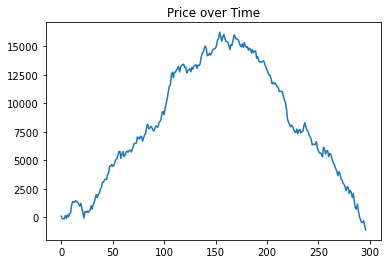

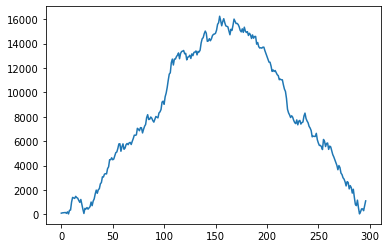

In [656]:
bought_in = 1
short_threshold = 100

initial_price = 100
buy_counter = 0
sell_counter = 0
redditor_count = 100
shorter_count = 10
short_interest = 0

n_days = array_sentiment_values.size
anxiety_data = np.zeros(n_days)
anxiety_array = np.zeros(redditor_count)
capitals_data = np.zeros(n_days)
capitals_array = np.zeros(redditor_count)
satisfaction_data = np.zeros(n_days)
satisfaction_array = np.zeros(redditor_count)
invested_data = np.zeros(n_days)
invested_array = np.zeros(redditor_count)

anxieties = np.random.normal(1, 0.3, size = redditor_count)
redditor_susceptebilities = np.random.normal(1, 0.3,  size = redditor_count)
redditor_capitals = np.random.exponential(100, size = redditor_count)

shorter_susceptebilites = np.random.normal(1, 0.3, size = shorter_count)
shorter_capitals = np.random.exponential(500, size = shorter_count)

market = Market(initial_price)
redditors = [Redditor(redditor_susceptebilities[i], 1, anxieties[i], redditor_capitals[i]) for i in range(redditor_count)]
shorters =[Shorter(shorter_susceptebilites[i], 100, shorter_capitals[i]) for i in range(shorter_count)]
prices = np.zeros(n_days)

for day in range(n_days):
    short_interest += 1
    
    for i in range(len(redditors)):
        buy = 0
        sell = 0
        if day >= 1:
            delta_price = prices[day-1] - prices[day - 2]
            redditors[i].convince(array_sentiment_values[day], delta_price)
        
        anxiety_array[i] = redditors[i].a 
        satisfaction_array[i] = redditors[i].fs
        capitals_array[i] = redditors[i].c
        invested_array[i] = redditors[i].invested
            
        buy, sell = redditors[i].buy_or_sell(prices[day-1], bought_in, buy, sell)
        buy_counter += buy
        sell_counter += sell
        
    for shorter in shorters:
        sell_counter += shorter.decide_short(market.price, short_interest, short_threshold, sell)
        buy_counter += shorter.short_counter(market.price, buy)

    anxiety_data[day] = np.mean(anxiety_array)
    satisfaction_data[day] = np.mean(satisfaction_array)
    invested_data[day] = np.mean(invested_array)
    capitals_data[day] = np.mean(capitals_array)
    prices[day] = market.price
    market.update_price(buy_counter, sell_counter)

plt.figure()
plt.plot(prices)
plt.title('Price over Time')
plt.savefig('price.png')
plt.show();

plt.figure()
plt.plot(np.absolute(prices))
plt.show();


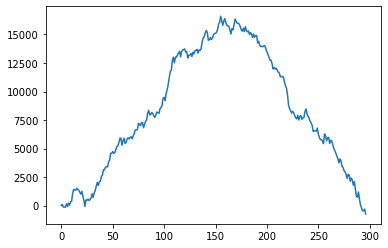

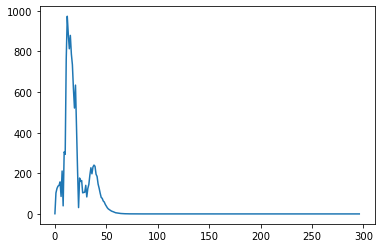

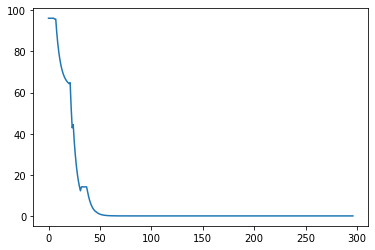

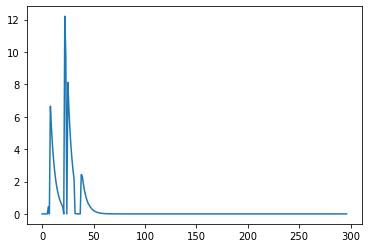

In [658]:
plt.figure()
plt.plot(anxiety_data)
plt.show();

plt.figure()
plt.plot(satisfaction_data)
plt.show();
